# Importing Necessary Packages

In [2]:
#for eda & visualisations
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#for ML
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

#for text mining
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk import ConditionalFreqDist
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

**Lemmatisation Approach :**
* For lemmatisation I've used the pywsd lib, which allows to lemmatise entire sentences rather than single words
* It is accurate as it automatically does POS tagging & then performs lemmatisation
* However, it is more time consuming because of above step

In [3]:
#pip install -U pywsd
#from pywsd.utils import lemmatize_sentence

In [4]:
job = pd.read_csv("../input/data job posts.csv")

In [5]:
job.head()

,jobpost,date,Title,Company,AnnouncementCode,Term,Eligibility,Audience,StartDate,Duration,...,Salary,ApplicationP,OpeningDate,Deadline,Notes,AboutC,Attach,Year,Month,IT
0,AMERIA Investment Consulting Company\nJOB TITL...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\nc...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
1,International Research & Exchanges Board (IREX...,"Jan 7, 2004",Full-time Community Connections Intern (paid i...,International Research & Exchanges Board (IREX),NaN,NaN,NaN,NaN,NaN,3 months,...,NaN,Please submit a cover letter and resume to:\nI...,NaN,12 January 2004,NaN,The International Research & Exchanges Board (...,NaN,2004,1,False
2,Caucasus Environmental NGO Network (CENN)\nJOB...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\nPOSITION,...,NaN,Please send resume or CV toursula.kazarian@......,NaN,20 January 2004\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\nn...,NaN,2004,1,False
3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Please send cover letter and resume to Amy\nPe...,NaN,23 January 2004\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False
4,Yerevan Brandy Company\nJOB TITLE: Software D...,"Jan 10, 2004",Software Developer,Yerevan Brandy Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Successful candidates should submit\n- CV; \n-...,NaN,"20 January 2004, 18:00",NaN,NaN,NaN,2004,1,True


In [6]:
job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19001 entries, 0 to 19000
Data columns (total 24 columns):
jobpost             19001 non-null object
date                19001 non-null object
Title               18973 non-null object
Company             18994 non-null object
AnnouncementCode    1208 non-null object
Term                7676 non-null object
Eligibility         4930 non-null object
Audience            640 non-null object
StartDate           9675 non-null object
Duration            10798 non-null object
Location            18969 non-null object
JobDescription      15109 non-null object
JobRequirment       16479 non-null object
RequiredQual        18517 non-null object
Salary              9622 non-null object
ApplicationP        18941 non-null object
OpeningDate         18295 non-null object
Deadline            18936 non-null object
Notes               2211 non-null object
AboutC              12470 non-null object
Attach              1559 non-null object
Year              

# Exploratory Data Analysis

In [7]:
sns.set(style='darkgrid')

Text(0.5, 1.0, 'Null-value Map')

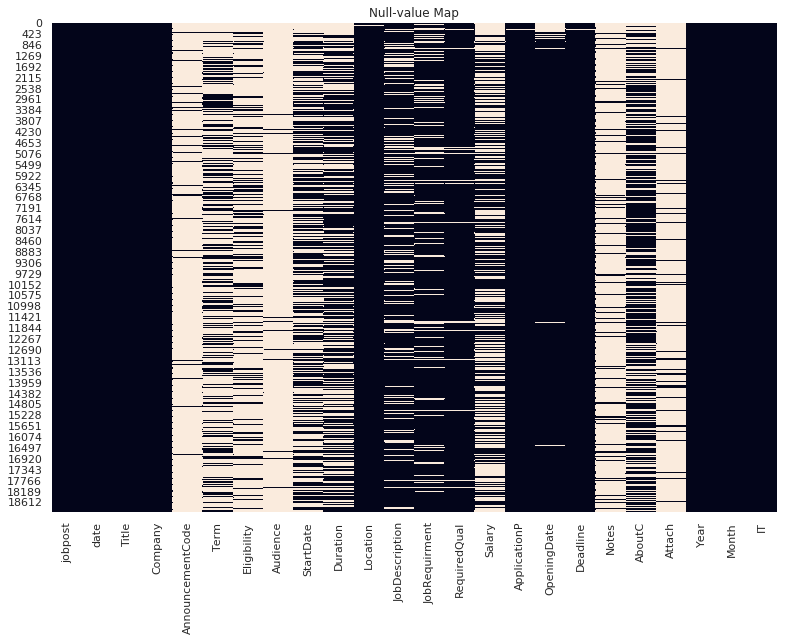

In [8]:
# creating null map
f=plt.figure(figsize=(13,9))
with sns.axes_style('dark'):
    sns.heatmap(job.isnull(), cbar=False)
plt.title('Null-value Map')

### EXPLANATION

* more than 10 columns contain null values
* Announcement code, Audience, Notes & Attach have too many nulls
* **TO BE NOTED** : the columns with nulls such as mentioned above are least important from our analysis point of view, eg : Attach describes if that particular job posting has any attachment or not, hence it is reasonable to either drop or ignore such vars.

Text(0.5, 0.98, 'Company & Job Title Trends')

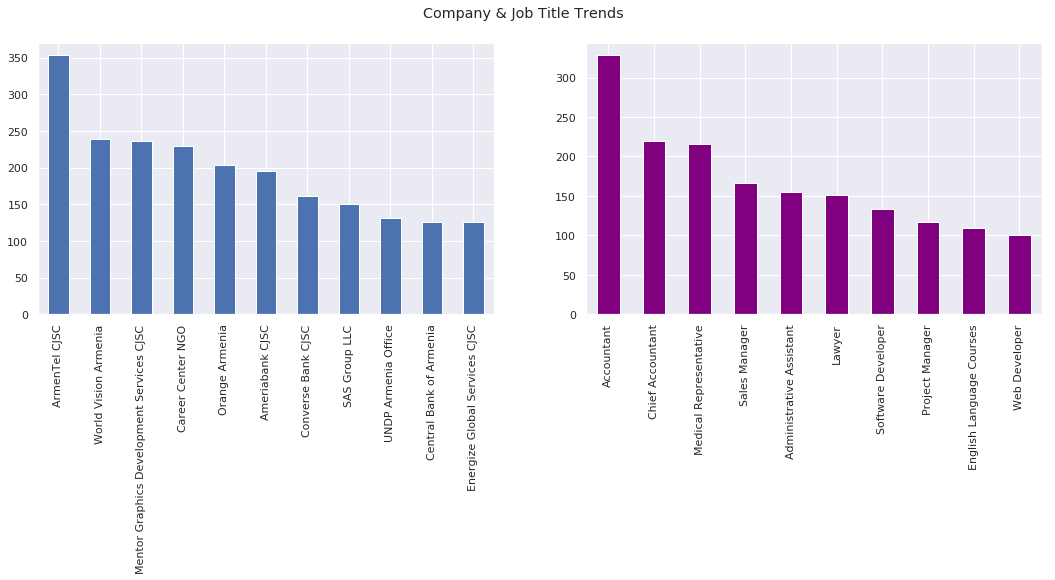

In [9]:
# plotting trends
f,ax = plt.subplots(1,2, figsize=(18,5))
job.Company.value_counts()[:11].plot(kind='bar', ax=ax[0])
job.Title.value_counts()[:10].plot(kind='bar', color='purple', ax=ax[1])
plt.suptitle('Company & Job Title Trends')

### PLOT EXPLANATION

**The 1st Plot**
* Shows the top 10 companies posting openings in the job portal
* AmenTel Joint Stock Company has the most job postings
* followed by World vision Armenia
* Most of them are LLC & Joint Stock Companies, and just one NGO-Career Center NGO

**2nd Plot explains that**
* demand for Accountant is the most in Armenia
* Next most job openings are in Medical Rep. field, followed by Sales Manager, Lawyer
* The top IT job openings are in Software Dev. line & Web Development

Text(0.5, 1.0, 'Year-wise Job Postings')

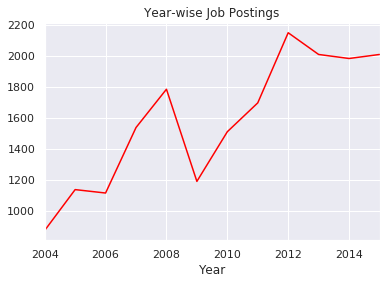

In [10]:
# Yearly trends
job.groupby('Year').jobpost.count().plot(kind='line', color='red')
plt.title('Year-wise Job Postings')

### EXPLANATION
* from the plot we may conclude that **in general** there has been an increasing trend in Job Postings for the decade(2004-2014)
* with an exception for the year 2008 - 2009 which saw drastic drop in job openings
* this drop in job postings may have occurred **due to global financial crisis of 2007-08**
* however, post 2009, the job openings once again picked up

Text(0.5, 1.0, 'Year-wise Job Postings')

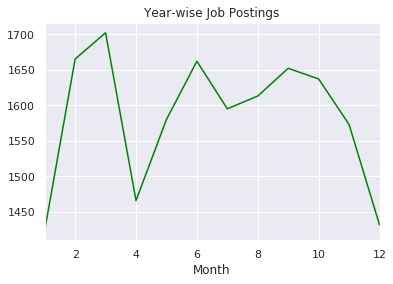

In [11]:
# Monthly trends
job.groupby('Month').jobpost.count().plot(kind='line', color='green')
plt.title('Year-wise Job Postings')

### EXPLANATION
* most job openings are posted early year -> Jan-Feb
* there is dip in job postings early mid year -> April, which may be due to **financial year closing**
* job postings rise again from June-July

Text(0.5, 1.0, 'Year-Month Breakup of JobPostings')

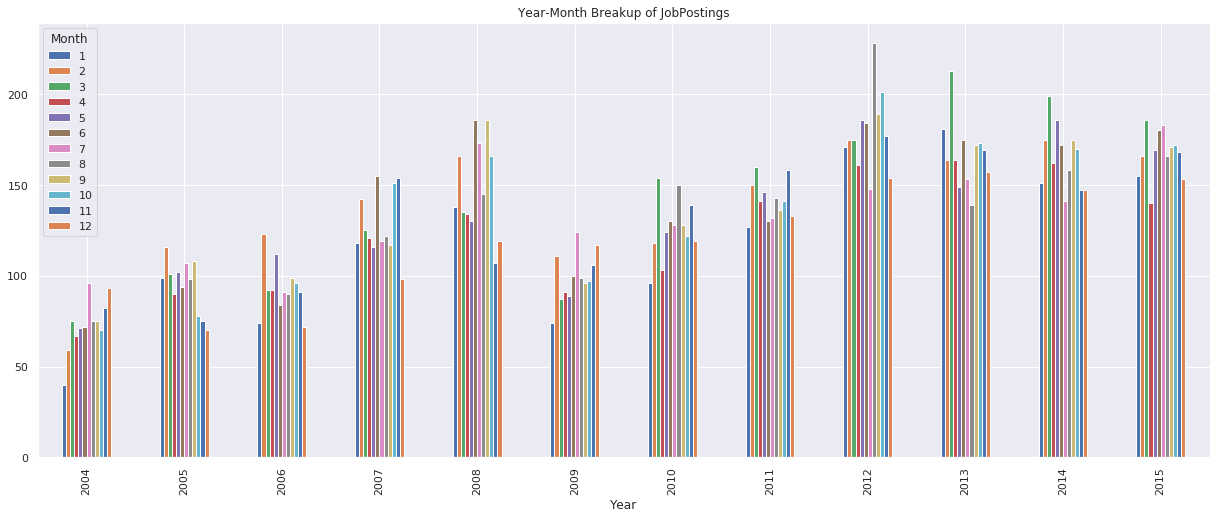

In [12]:
# year - month trend
df1 = job.groupby(['Year','Month']).jobpost.count()
df1.unstack().plot(kind='bar',figsize=(21,8))
plt.title('Year-Month Breakup of JobPostings')

### EXPLANATION :
* in general, the no. of job postings have increased over the year
* the above plot also affirms the effect of 2007-08 global financial crisis on job postings & Armenian economy
* the year 2012 has most job postings
* followed by 2013
* post 2012, the job openings/postings have been high

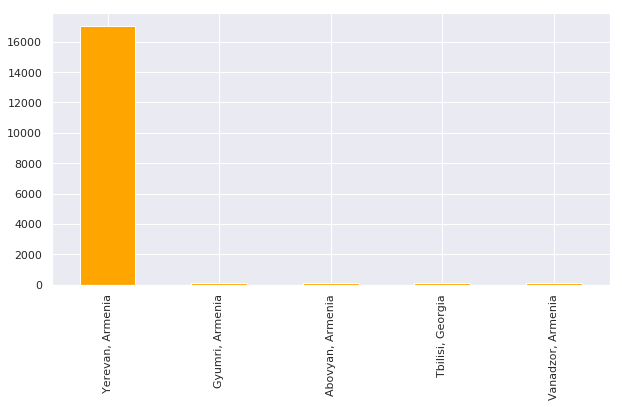

In [13]:
job.Location.value_counts()[:5].plot(kind='bar',color='orange',figsize=(10,5))

### EXPLANATION
* more than 80% of the jobs are for the location Yerevan which is the **CAPITAL CITY**
* the other cities where job openings are Gyumri, Abovyan, Tbilisi & Vanadzor

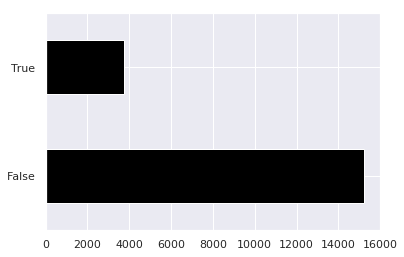

In [14]:
job.IT.value_counts().plot.barh(color='black')

### EXPLANATION
* about 80% of the job postings are for non-IT sector

Text(0.5, 1.0, 'Top 10 IT Job Openings')

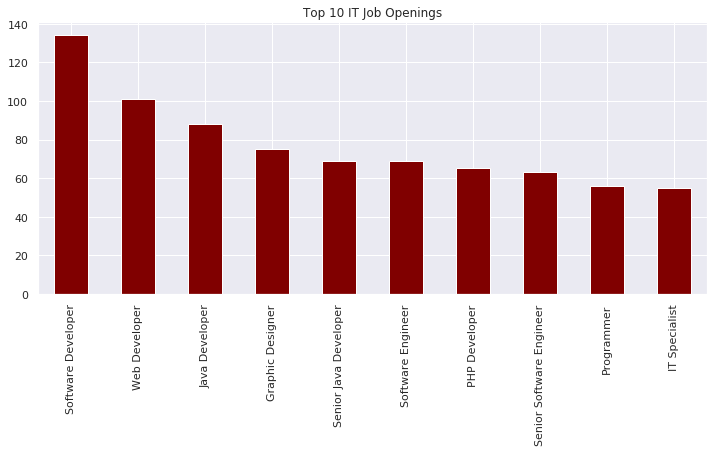

In [15]:
job[job.IT==True].Title.value_counts()[:10].plot(kind='bar', color='maroon',figsize=(12,5))
plt.title('Top 10 IT Job Openings')

### EXPLANATION
* among the IT jobs the most openings are in Software Development field
* followed by Web Development, JAVA dev. & Graphic Designing

# Data Wrangling

### Approach 
* Since our aim is to analyse the text  in these job postings, only the following columns may be useful from analysis point of view
* 'jobpost' , 'Title' , 'JobRequirment' , 'JobDescription' , 'RequiredQual' , 'AboutC' , 'Year' , 'IT'
* "IT" is a bool type feature which serves as target for classifying jobposts into IT or not

In [16]:
job2 = job[['jobpost','Title','JobRequirment','JobDescription','RequiredQual','AboutC', 'Year','IT']].copy()
job2.head()

,jobpost,Title,JobRequirment,JobDescription,RequiredQual,AboutC,Year,IT
0,AMERIA Investment Consulting Company\nJOB TITL...,Chief Financial Officer,- Supervises financial management and administ...,AMERIA Investment Consulting Company is seekin...,"To perform this job successfully, an\nindividu...",NaN,2004,False
1,International Research & Exchanges Board (IREX...,Full-time Community Connections Intern (paid i...,NaN,NaN,- Bachelor's Degree; Master's is preferred;\n-...,The International Research & Exchanges Board (...,2004,False
2,Caucasus Environmental NGO Network (CENN)\nJOB...,Country Coordinator,- Working with the Country Director to provide...,Public outreach and strengthening of a growing...,"- Degree in environmentally related field, or ...",The Caucasus Environmental NGO Network is a\nn...,2004,False
3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,BCC Specialist,- Identify gaps in knowledge and overseeing in...,The LEAD (Local Enhancement and Development fo...,"- Advanced degree in public health, social sci...",NaN,2004,False
4,Yerevan Brandy Company\nJOB TITLE: Software D...,Software Developer,- Rendering technical assistance to Database M...,NaN,- University degree; economical background is ...,NaN,2004,True


In [17]:
# duplicate removal
job2.drop_duplicates(subset=['jobpost','Title'],keep='first', inplace=True) #keeping first occurence of obs while dropping other duplicate obs.

In [19]:
# since we are dealing with text data it is logical to impute NaNs with blank string
job2.fillna(' ',inplace=True)

In [20]:
job2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18892 entries, 0 to 19000
Data columns (total 8 columns):
jobpost           18892 non-null object
Title             18892 non-null object
JobRequirment     18892 non-null object
JobDescription    18892 non-null object
RequiredQual      18892 non-null object
AboutC            18892 non-null object
Year              18892 non-null int64
IT                18892 non-null bool
dtypes: bool(1), int64(1), object(6)
memory usage: 1.2+ MB


In [21]:
job2.head()

,jobpost,Title,JobRequirment,JobDescription,RequiredQual,AboutC,Year,IT
0,AMERIA Investment Consulting Company\nJOB TITL...,Chief Financial Officer,- Supervises financial management and administ...,AMERIA Investment Consulting Company is seekin...,"To perform this job successfully, an\nindividu...",,2004,False
1,International Research & Exchanges Board (IREX...,Full-time Community Connections Intern (paid i...,,,- Bachelor's Degree; Master's is preferred;\n-...,The International Research & Exchanges Board (...,2004,False
2,Caucasus Environmental NGO Network (CENN)\nJOB...,Country Coordinator,- Working with the Country Director to provide...,Public outreach and strengthening of a growing...,"- Degree in environmentally related field, or ...",The Caucasus Environmental NGO Network is a\nn...,2004,False
3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,BCC Specialist,- Identify gaps in knowledge and overseeing in...,The LEAD (Local Enhancement and Development fo...,"- Advanced degree in public health, social sci...",,2004,False
4,Yerevan Brandy Company\nJOB TITLE: Software D...,Software Developer,- Rendering technical assistance to Database M...,,- University degree; economical background is ...,,2004,True


In [22]:
# created set of stopwprds from NLTK lib
stopeng = list(stopwords.words('english'))

# since we are dealing with armenian job postings the follwoing words may be considered stopwords/unwanted words from analysis point of view
stopeng.extend(['armenian','armenia','job','title','position','location','responsibilities','applications','procedures','deadline',
                'required','qualifications','renumeration','salary','date','company','llc','least','year','years','please'])
stopeng = set(stopeng)

In [23]:
# text cleaning

def cleaner(t):
    #for URL removal
    t = re.sub(r"(http://)|(https://)|(www.)([a-zA-Z]+)(.)([a-zA-Z]{2,3})", '',t)     
    
    #for email substitution
    t = re.sub('\S+@\S+', '' ,t)   
    
    #spl. char removal
    t = re.sub(r"[-()\"#/@;:{}&`+=~|.!?,']", "", t)
    
    # double space removal
    t = re.sub("  "," ",t)        
    
    #numeral removal
    t = re.sub(r'[0-9]+', '', t)     
    
    # newline removal
    t = re.sub(r'\n',' ',t)
    
    #stripping and case change
    t = t.strip()
    t = t.lower()
    
    #stopwords removal
    t = ' '.join(c for c in t.split() if c not in stopeng)
    return t

In [24]:
job2.jobpost = job2.jobpost.apply(cleaner)
job2.JobRequirment = job2.JobRequirment.apply(cleaner)
job2.JobDescription = job2.JobDescription.apply(cleaner)
job2.RequiredQual = job2.RequiredQual.apply(cleaner)
job2.AboutC = job2.AboutC.apply(cleaner)
job2.Title = job2.Title.apply(cleaner)

In [25]:
# UDF for performing lemmatisation
def lemma(t):
    t = lemmatize_sentence(t)  # from pyswd package
    t = " ".join(t)
    return t

In [26]:
#job2.jobpost = job2.jobpost.apply(lemma)
#job2.JobRequirment = job2.JobRequirment.apply(lemma)
#job2.JobDescription = job2.JobDescription.apply(lemma)
#job2.RequiredQual = job2.RequiredQual.apply(lemma)
#job2.AboutC = job2.AboutC.apply(lemma)
#job2.Title = job2.Title.apply(lemma)

In [27]:
job2.Title.value_counts()[:10]

accountant                  328
medical representative      226
chief accountant            220
sales manager               166
administrative assistant    156
lawyer                      151
software developer          137
project manager             124
web developer               101
java developer               90
Name: Title, dtype: int64

In [28]:
# UDF for WORDCLOUD creation

from functools import reduce
def cloud_cr8r(c):
    quals = reduce(lambda x,y: x+y, c)  # reducing nested list to simple lists
    unique_string=(" ").join(quals)
    wc = WordCloud(width = 1000, height = 500, background_color='black').generate(unique_string)
    plt.figure(figsize=(15,8))
    plt.imshow(wc)
    plt.axis("off")
    plt.show()

# Analysing "Description" of jobs

In [29]:
accntnt_desc = job2[job2.Title=='accountant']['JobDescription'].apply(lambda t : t.split())
lawyer_desc = job2[job2.Title=='lawyer']['JobDescription'].apply(lambda t : t.split())
sfdev_desc = job2[job2.Title=='software developer']['JobDescription'].apply(lambda t : t.split())
wbdev_desc = job2[job2.Title=='web developer']['JobDescription'].apply(lambda t : t.split())

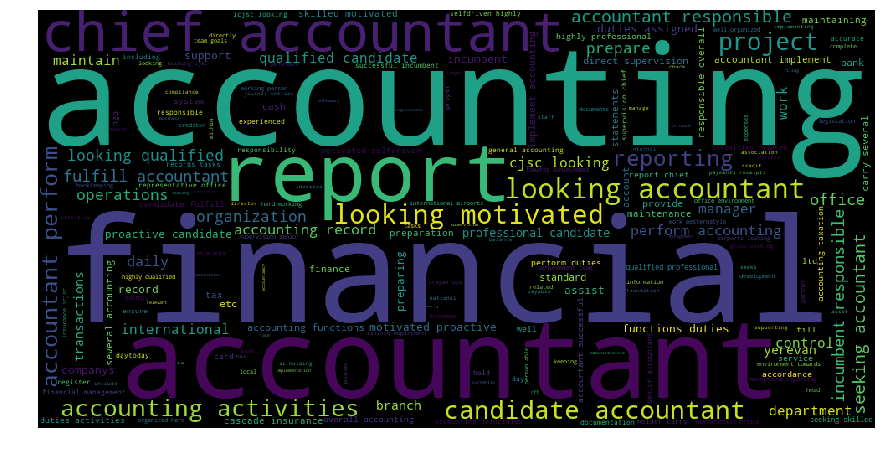

In [30]:
cloud_cr8r(accntnt_desc) # job description for accountant which is the top job

### EXPLANATION
* the above wordcloud explains the job description for **accountant posts**
* most job postings for accountant look for qualified, motivated candidates
* with knowledge in reporting, project implementation
* also many accountant jobs are for the post of chief accountant

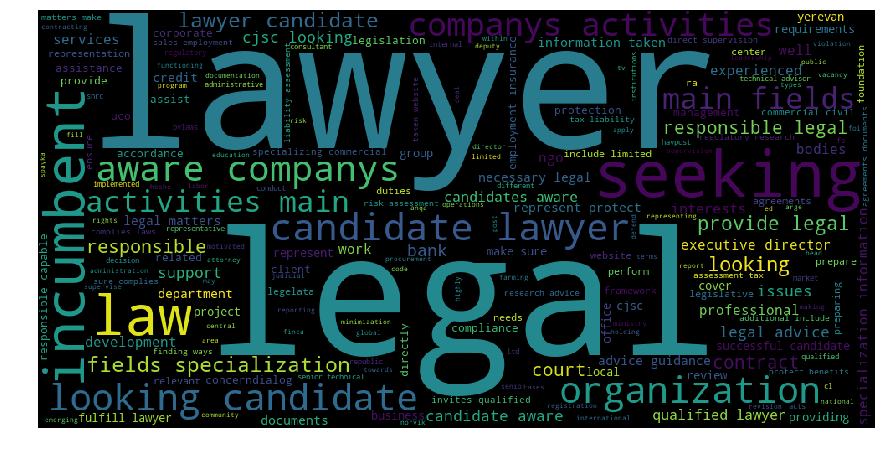

In [31]:
cloud_cr8r(lawyer_desc) # job description for lawyers

### EXPLANATION
* the above wordcloud describes **lawyer jobs description**
* should be legal practitioner
* should be aware of company laws
* familiar with legislations

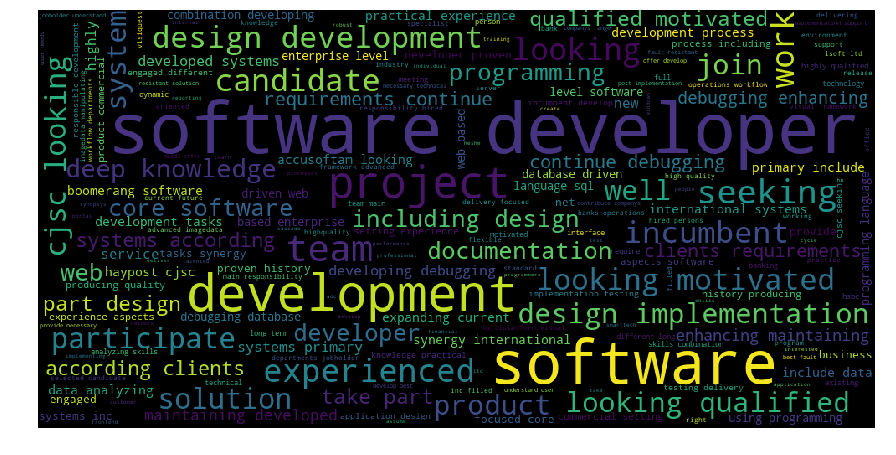

In [32]:
cloud_cr8r(sfdev_desc) # job description for software developers

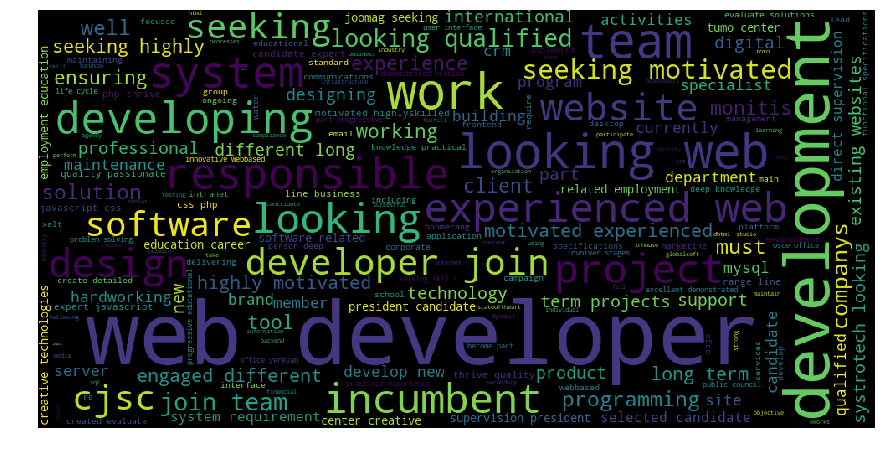

In [33]:
cloud_cr8r(wbdev_desc) # job description for web developers

### EXPLANATION
* for web development most jobs look for
* motivated, well experienced candidates
* adept with softwares, designing

# Analysing "Qualifications" of Jobs

In [34]:
accntnt_qual = job2[job2.Title=='accountant']['RequiredQual'].apply(lambda t : t.split())
lawyer_qual = job2[job2.Title=='lawyer']['RequiredQual'].apply(lambda t : t.split())
sfdev_qual = job2[job2.Title=='software developer']['RequiredQual'].apply(lambda t : t.split())
wbdev_qual = job2[job2.Title=='web developer']['RequiredQual'].apply(lambda t : t.split())

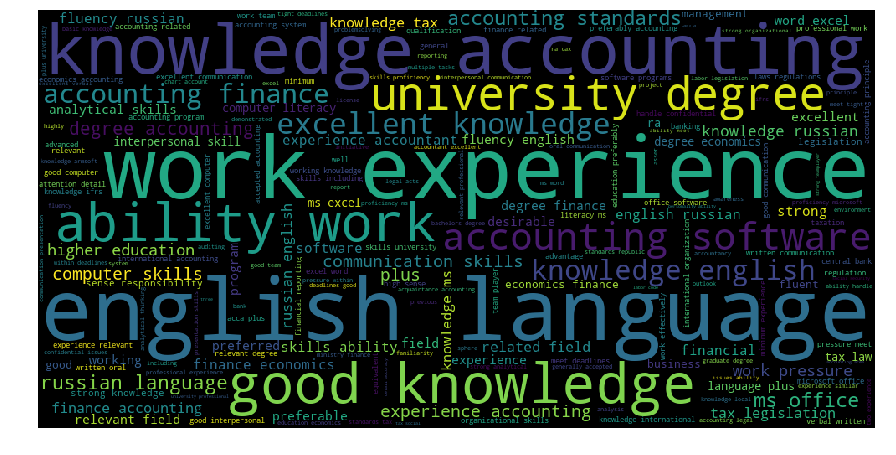

In [35]:
cloud_cr8r(accntnt_qual) # required qualifications for accountant

### EXPLANATION
* Most **demanded Qualifications for accountant** jobs are :
    * good work experience is preferred
    * a knowledge of english language
    * should know to work on accounting software, MS-EXCEL, Office
    * should be aware of various accounting standards
    * should hold university degree
    * have good communication skills

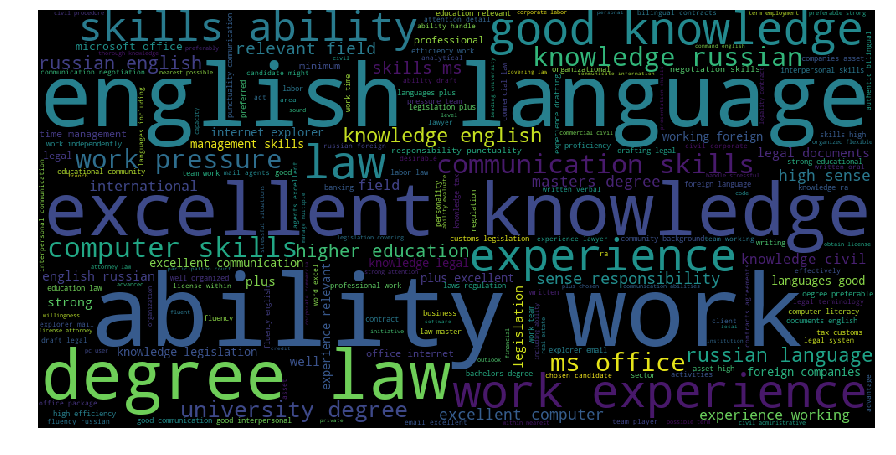

In [36]:
cloud_cr8r(lawyer_qual) # required qualifications for lawyers

### EXPLANATION
* Most **demanded Qualifications for Lawyer postings**
    * higher education, a degree in law
    * excellent knowledge
    * good work experience
    * proficiency in english and russian language
    * computer skills is preferred too

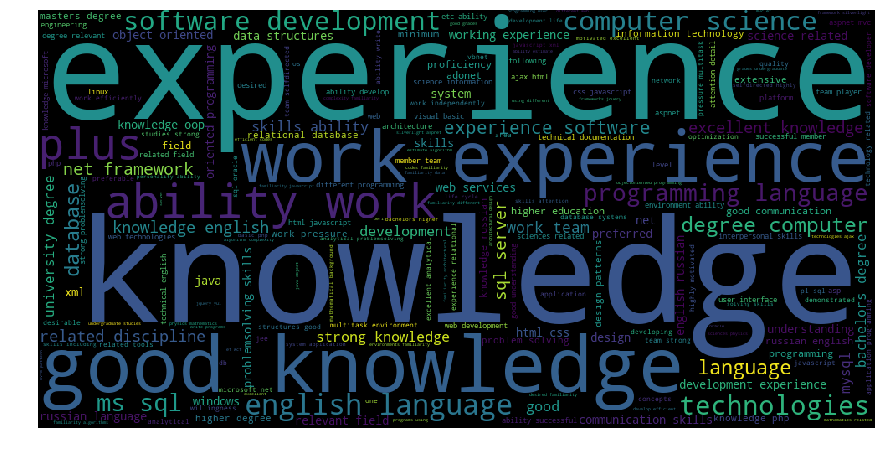

In [37]:
cloud_cr8r(sfdev_qual) # required qualifications for software developers

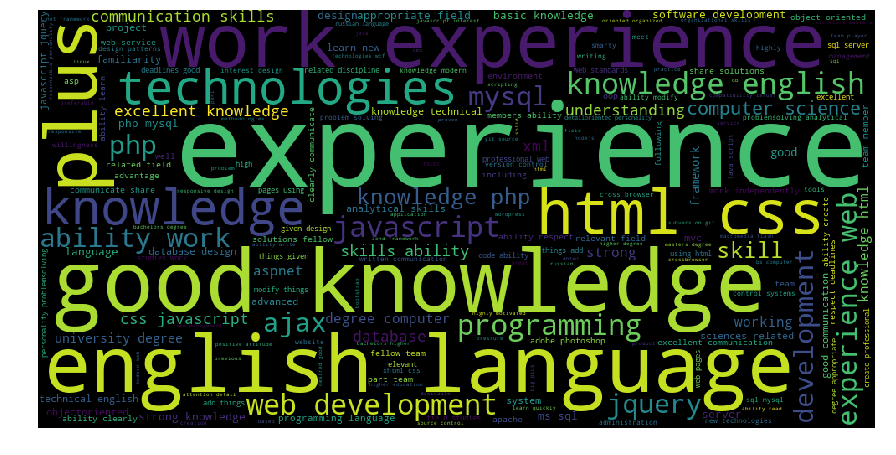

In [38]:
cloud_cr8r(wbdev_qual)# required qualifications for web developers

### EXPLANATION
* **Demanded Qualifications for a Web Developer post**
    * good experience in the field
    * good knowledge
    * english language
    * html coding and CSS
    * knowledge of JAVASCRIPT & php
    * also mySQL

# Analysing demand over time

## Analysing Desired Qualifications for Accountant post for period 2004-2015

**APPROACH :**
* filtering accountant requirements year wise

* creating (year, qualifications) pair, where year = categorical & qualifications taken from corpus

* using **CONDITIONAL FREQUENCY DISTRIBUTION** from NLTK for analysis

In [39]:
acnt_04=job2[(job2.Title=='accountant')&(job2.Year==2004)]['RequiredQual']
acnt_06=job2[(job2.Title=='accountant')&(job2.Year==2006)]['RequiredQual']
acnt_08=job2[(job2.Title=='accountant')&(job2.Year==2008)]['RequiredQual']
acnt_10=job2[(job2.Title=='accountant')&(job2.Year==2010)]['RequiredQual']
acnt_15=job2[(job2.Title=='accountant')&(job2.Year==2015)]['RequiredQual']

In [40]:
# UDF to split & extend series of strings
def pairer(t,y):
    lister=[]
    t=t.split()
    lister.extend([(y,i) for i in t])
    return lister

acnt_04=acnt_04.apply(lambda t: pairer(t,2004))  #qualification for year 2004
acnt_06=acnt_06.apply(lambda t: pairer(t,2006))  #qualification for year 2006
acnt_08=acnt_08.apply(lambda t: pairer(t,2008))  #qualification for year 2008
acnt_10=acnt_10.apply(lambda t: pairer(t,2010))  #qualification for year 2010
acnt_15=acnt_15.apply(lambda t: pairer(t,2015))  #qualification for year 2015

In [41]:
acnt_06[:10]

2058    [(2006, university), (2006, professional), (20...
2063    [(2006, advanced), (2006, degree), (2006, acco...
2094    [(2006, higher), (2006, education), (2006, acc...
2095    [(2006, higher), (2006, education), (2006, acc...
2105    [(2006, university), (2006, degree), (2006, fi...
2115    [(2006, university), (2006, degree), (2006, re...
2210    [(2006, university), (2006, degree), (2006, re...
2305    [(2006, relevant), (2006, university), (2006, ...
2309    [(2006, higher), (2006, education), (2006, wor...
2348    [(2006, higher), (2006, education), (2006, min...
Name: RequiredQual, dtype: object

In [42]:
acnt_15[:10]

17014    [(2015, graduate), (2015, degree), (2015, acco...
17098    [(2015, university), (2015, degree), (2015, pr...
17174    [(2015, higher), (2015, education), (2015, eco...
17195    [(2015, knowledge), (2015, software), (2015, k...
17226    [(2015, university), (2015, degree), (2015, fi...
17292    [(2015, experience), (2015, working), (2015, a...
17442    [(2015, university), (2015, degree), (2015, ac...
17619    [(2015, university), (2015, degree), (2015, fi...
17651    [(2015, university), (2015, degree), (2015, fi...
17655    [(2015, work), (2015, experience), (2015, acco...
Name: RequiredQual, dtype: object

In [43]:
# for reduction into simple list of tuples
acnt_04=reduce(lambda x,y : x+y, acnt_04)
acnt_06=reduce(lambda x,y : x+y, acnt_06)
acnt_08=reduce(lambda x,y : x+y, acnt_08)
acnt_10=reduce(lambda x,y : x+y, acnt_10)
acnt_15=reduce(lambda x,y : x+y, acnt_15)

In [44]:
#concatenating all trends across diff. years
acnt_final_req = acnt_04 + acnt_06 + acnt_08 + acnt_10 + acnt_15

In [45]:
# using conditional frequency distribution from nltk
acnt_final_req_freq = ConditionalFreqDist(acnt_final_req)

In [46]:
# creating tabular form
yrs = acnt_final_req_freq.conditions()
wrds = ['accounting','knowledge','finance','communication','english','software','standards','ms']   # from wordcloud these are some of most occurring words
acnt_final_req_freq.tabulate(conditions=yrs, samples=wrds)

        accounting     knowledge       finance communication       english      software     standards            ms 
2004            34            33             6            12            15             7             6             7 
2006            66            55            13             8            18            16            11             6 
2008            86            82            21            13            29            32            14            14 
2010            33            57            17             7            19            14            10            10 
2015            58            74            25            15            19            17             3            17 


### EXPLANATION
* From the above table we may conclude the following for ACCOUNTING JOBS  :
    * requirement of good knowledge in accounting has remained in high demand throughout the years under analysis
    * requirement for knowledge in finance has increased from 2004 to 2015
    * demand for english language as a requirement has been stable over the years
    * knowledge of accounting software as a requirement has increased
    * also knowledge of MS Office tools as qualification has increased

## Analysing Desired Qualifications for S.W Developer post for the period 2004-2015

In [47]:
sfd_04=job2[(job2.Title=='software developer')&(job2.Year==2004)]['RequiredQual']
sfd_05=job2[(job2.Title=='software developer')&(job2.Year==2005)]['RequiredQual']
sfd_06=job2[(job2.Title=='software developer')&(job2.Year==2006)]['RequiredQual']
sfd_07=job2[(job2.Title=='software developer')&(job2.Year==2007)]['RequiredQual']
sfd_08=job2[(job2.Title=='software developer')&(job2.Year==2008)]['RequiredQual']
sfd_09=job2[(job2.Title=='software developer')&(job2.Year==2009)]['RequiredQual']
sfd_10=job2[(job2.Title=='software developer')&(job2.Year==2010)]['RequiredQual']
sfd_11=job2[(job2.Title=='software developer')&(job2.Year==2011)]['RequiredQual']
sfd_12=job2[(job2.Title=='software developer')&(job2.Year==2012)]['RequiredQual']
sfd_13=job2[(job2.Title=='software developer')&(job2.Year==2013)]['RequiredQual']
sfd_14=job2[(job2.Title=='software developer')&(job2.Year==2014)]['RequiredQual']
sfd_15=job2[(job2.Title=='software developer')&(job2.Year==2015)]['RequiredQual']

In [48]:
sfd_04=sfd_04.apply(lambda t: pairer(t,2004))
sfd_05=sfd_05.apply(lambda t: pairer(t,2005))
sfd_06=sfd_06.apply(lambda t: pairer(t,2006)) 
sfd_07=sfd_07.apply(lambda t: pairer(t,2007))
sfd_08=sfd_08.apply(lambda t: pairer(t,2008))  
sfd_09=sfd_09.apply(lambda t: pairer(t,2009))
sfd_10=sfd_10.apply(lambda t: pairer(t,2010))  
sfd_11=sfd_11.apply(lambda t: pairer(t,2011))
sfd_12=sfd_12.apply(lambda t: pairer(t,2012))
sfd_13=sfd_13.apply(lambda t: pairer(t,2013))
sfd_14=sfd_14.apply(lambda t: pairer(t,2014))
sfd_15=sfd_15.apply(lambda t: pairer(t,2015))

In [49]:
sfd_04=reduce(lambda x,y : x+y, sfd_04)
sfd_05=reduce(lambda x,y : x+y, sfd_05)
sfd_06=reduce(lambda x,y : x+y, sfd_06)
sfd_07=reduce(lambda x,y : x+y, sfd_07)
sfd_08=reduce(lambda x,y : x+y, sfd_08)
sfd_09=reduce(lambda x,y : x+y, sfd_09)
sfd_10=reduce(lambda x,y : x+y, sfd_10)
sfd_11=reduce(lambda x,y : x+y, sfd_11)
sfd_12=reduce(lambda x,y : x+y, sfd_12)
sfd_13=reduce(lambda x,y : x+y, sfd_13)
sfd_14=reduce(lambda x,y : x+y, sfd_14)
sfd_15=reduce(lambda x,y : x+y, sfd_15)

sfd_final_req = sfd_04 + sfd_05 + sfd_06 + sfd_07 + sfd_08 + sfd_09 + sfd_10 + sfd_11 + sfd_12 + sfd_13 + sfd_14 + sfd_15

In [50]:
sfd_final_req_freq = ConditionalFreqDist(sfd_final_req)

yrs = sfd_final_req_freq.conditions()
wrds = ['programming','database','sql','server','java','oop','technologies','english','experience']   # from wordcloud these are some of most occurring words
sfd_final_req_freq.tabulate(conditions=yrs, samples=wrds)

      programming     database          sql       server         java          oop technologies      english   experience 
2004            5            4            3            2            3            0            5            4           12 
2005            9            7            8            0           12            1            8           12           43 
2006            8            3           13            6            5            0            4            9           24 
2007           12            4            9            3            4            1            3            8           20 
2008            6            0            5            4            0            1            3            4           18 
2009            3            1            6            4            1            2            3            5           25 
2010            1            0            2            1            1            2            1            1            7 
2011            

### EXPLANATION
* From the above table we may conclude the following for SOFTWARE DEV. Jobs
    * knowledge of programming as required qualification has increased from 2004-2015
    * database knowledge requirement has remained static
    * demand for SQL has also increased and so for knowledge on OOPs concept
    * however demand for JAVA has slumped
    * english demand has seen a rise over the years
    * over the years 2004-2015 there is high demand for well experienced candidates

# Analysing "About the Companies"

**USING FREQDIST from NLTK**

In [51]:
abc = job2.AboutC.apply(lambda t : t.split())
abc_list = reduce(lambda x,y :x+y, abc)

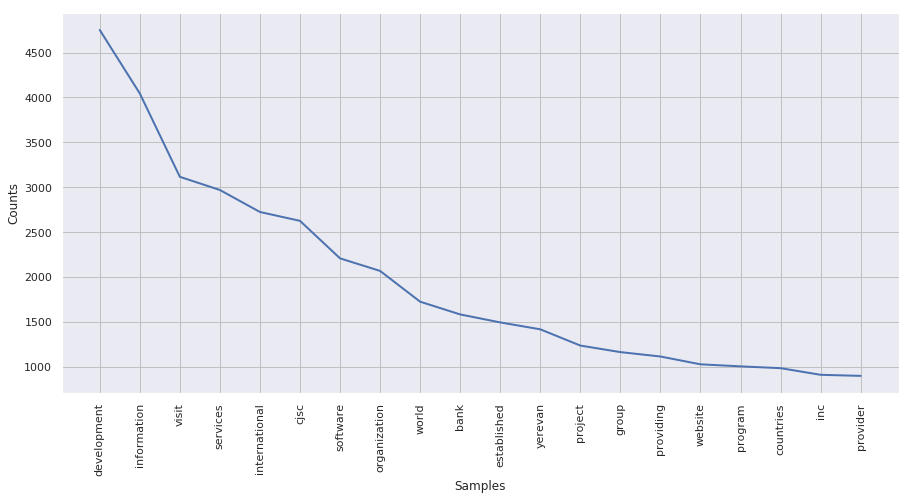

In [52]:
abc_dist=FreqDist(abc_list)
plt.figure(figsize=(15,7))
abc_dist.plot(20)

### EXPLANATION
* From the above freq. plot we may conclude that
    * most companies are in development sector
    * followed by IT sector and Service sector
    * Many of them are international companie
    * Many of them are based out of the capital city of Yerevan

# Analysing types of Jobs in demand in Armenia

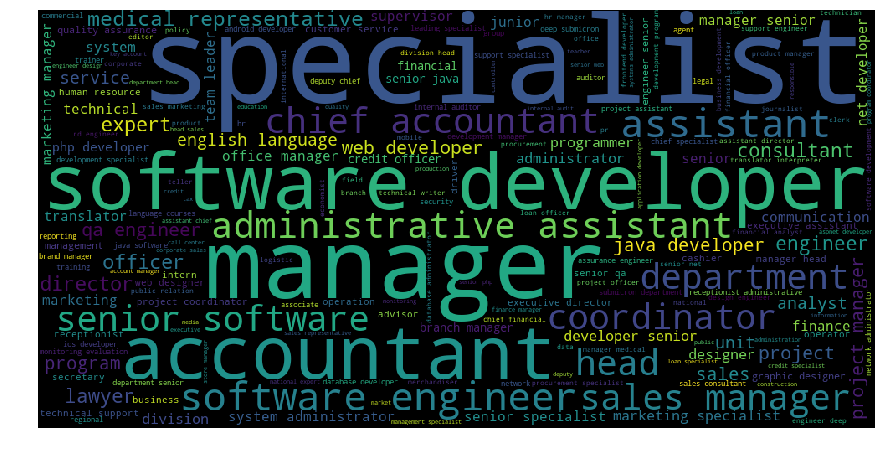

In [53]:
tit = job2.Title.apply(lambda t: t.split())
cloud_cr8r(tit)

In [54]:
jtit_4 = (job2[job2.Year==2004]['Title'])

jtit_6 = (job2[job2.Year==2006]['Title'])

jtit_8 = (job2[job2.Year==2008]['Title'])

jtit_10 = (job2[job2.Year==2010]['Title'])

jtit_12 = (job2[job2.Year==2012]['Title'])

jtit_15 = (job2[job2.Year==2015]['Title'])

In [55]:
jt_4 = jtit_4.apply(lambda t: pairer(t,2004))
jt_6 = jtit_6.apply(lambda t: pairer(t,2006))
jt_8 = jtit_8.apply(lambda t: pairer(t,2008))
jt_10 = jtit_10.apply(lambda t: pairer(t,2010))
jt_12 = jtit_12.apply(lambda t: pairer(t,2012))
jt_15 = jtit_15.apply(lambda t: pairer(t,2015))

In [56]:
jt4 = reduce(lambda x,y : x+y, jt_4)
jt6 = reduce(lambda x,y : x+y, jt_6)
jt8 = reduce(lambda x,y : x+y, jt_8)
jt10 = reduce(lambda x,y : x+y, jt_10)
jt12 = reduce(lambda x,y : x+y, jt_12)
jt15 = reduce(lambda x,y : x+y, jt_15)

jt_final = jt4+ jt6+ jt8+ jt10+ jt12+ jt15

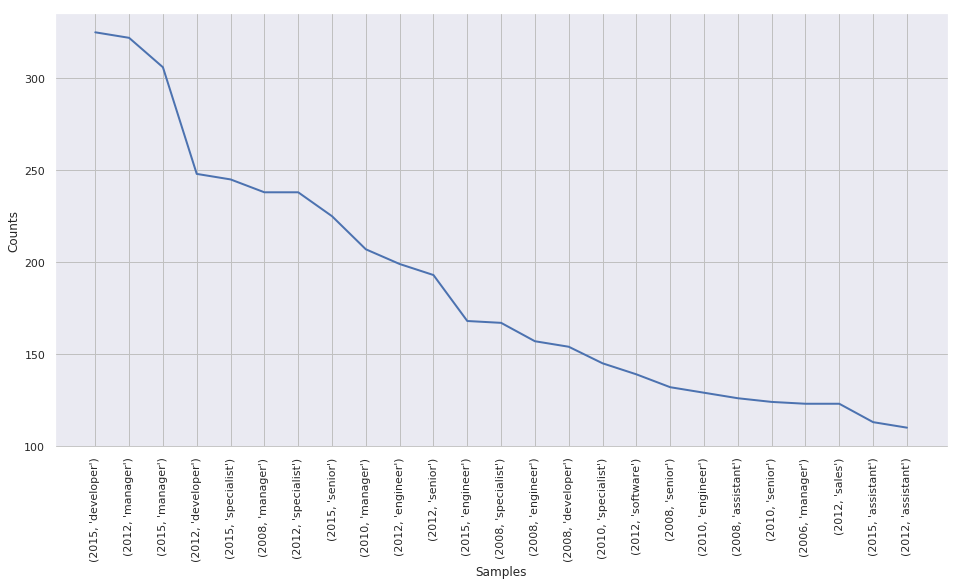

In [57]:
jt_dist = FreqDist(jt_final)
plt.figure(figsize=(16,8))
jt_dist.plot(25)

In [58]:
jt_final_freq = ConditionalFreqDist(jt_final)

yrs = jt_final_freq.conditions()
wrds = ['administrative', 'developer', 'medical', 'engineer', 'manager', 'sales', 'specialist','assistant']   # from wordcloud these are some of most occurring words
jt_final_freq.tabulate(conditions=yrs, samples=wrds)

     administrative      developer        medical       engineer        manager          sales     specialist      assistant 
2004             32             59              6             51             90             19             45             70 
2006             41             89             21             74            123             41            101             98 
2008             44            154             21            157            238             83            167            126 
2010             35            105             55            129            207             66            145            108 
2012             32            248             42            199            322            123            238            110 
2015             46            325             20            168            306             88            245            113 


### EXPLANATION
* The most demanded jobs in Armenia for the period 2004-2015 are 
    * Developer jobs which is IT sector
    * followed by managerial & specialist posts
    * there is also high demand for engineers
    * demand for Sales jobs has also risen

* The freq. table describes the trend of the jobs over time
    * developer jobs, engineering jobs, managerial posts have increased over time

# IT Job Classification

**APPROACH**
* Classifying whether a job is IT or not based on JOBPOST column
* text from jobpost column will be cleansed, tokenised, lemmatised and used as features for classification
* used both term frequency and tf-idf
* Naive Bayes used for classification

In [59]:
it=job2[['jobpost','IT']]
it

,jobpost,IT
0,ameria investment consulting chief financial o...,False
1,international research exchanges board irex fu...,False
2,caucasus environmental ngo network cenn countr...,False
3,manoff group bcc specialist manila philippines...,False
4,yerevan brandy software developer yerevan rend...,True
...,...,...
18996,technolinguistics ngo senior creative ux ui de...,False
18997,cocacola hellenic bottling cjsc category devel...,False
18998,cocacola hellenic bottling cjsc operational ma...,False
18999,san lazzaro head online sales department durat...,False


In [60]:
it.IT = it.IT.map({False:0, True:1})
it.head()

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,jobpost,IT
0,ameria investment consulting chief financial o...,0
1,international research exchanges board irex fu...,0
2,caucasus environmental ngo network cenn countr...,0
3,manoff group bcc specialist manila philippines...,0
4,yerevan brandy software developer yerevan rend...,1


In [61]:
#it.jobpost = it.jobpost.apply(lemma)

In [62]:
# separating feature and target
X = it.jobpost
y = it.IT

In [63]:
# train-test split
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=12345)

In [64]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(13224,)
(13224,)
(5668,)
(5668,)


In [65]:
# for creating unigrams
cvect = CountVectorizer(analyzer='word', ngram_range=(1,1), encoding='latin-1') # creating unigrams

In [66]:
trainx_cnt = cvect.fit_transform(train_x)

In [67]:
# creating document term matrix (matrix of term frequencies)
train_x_dtm = pd.DataFrame(trainx_cnt.toarray(), columns=cvect.get_feature_names())
print(train_x_dtm.shape)

(13224, 29033)


In [68]:
testx_cnt=cvect.transform(test_x)
test_x_dtm = pd.DataFrame(testx_cnt.toarray(), columns=cvect.get_feature_names())
print(test_x_dtm.shape)

(5668, 29033)


In [69]:
gnb = GaussianNB()
gnb.fit(train_x_dtm, train_y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [70]:
train_pred_gnb = gnb.predict(train_x_dtm)
test_pred_gnb = gnb.predict(test_x_dtm)

Text(0.5, 0.98, 'Confusion Matrices - DTM(tf) used')

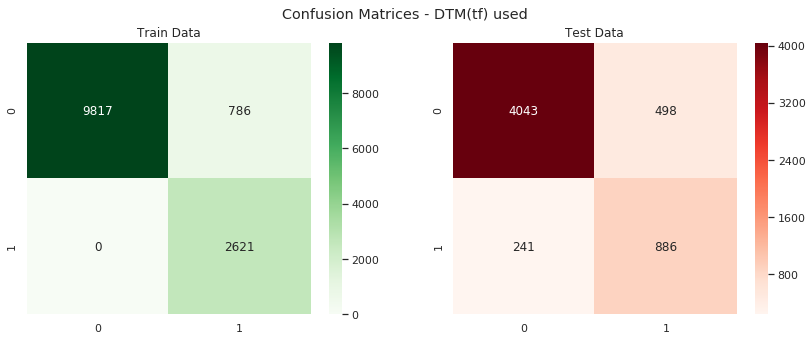

In [71]:
f,ax = plt.subplots(1,2, figsize=(14,5))
sns.heatmap(metrics.confusion_matrix(train_y, train_pred_gnb), annot=True, fmt='d', cmap='Greens',ax=ax[0])
ax[0].set_title('Train Data')
sns.heatmap(metrics.confusion_matrix(test_y, test_pred_gnb), annot=True, fmt='d', cmap='Reds',ax=ax[1])
ax[1].set_title('Test Data')
plt.suptitle('Confusion Matrices - DTM(tf) used')

In [72]:
sns.set(style='whitegrid')

Text(0.5, 1.0, 'Accuracy Scores (DTM) (Green=Train & Red = Test)')

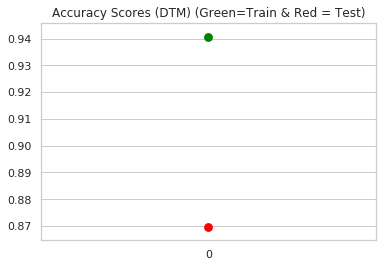

In [73]:
sns.pointplot(data=[metrics.accuracy_score(train_y, train_pred_gnb)], color='Green', label='Train')
sns.pointplot(data=[metrics.accuracy_score(test_y, test_pred_gnb)], color = 'Red', label="Test")
plt.title('Accuracy Scores (DTM) (Green=Train & Red = Test)')

### EXPLANATION
* The false positives and true negatives are not very much for both train & test data
* also get high accuracy for both train (~ 94%) & test (~ 87%)

In [74]:
# tf-idf
tf_trans = TfidfVectorizer(analyzer='word', ngram_range=(1,1), strip_accents='unicode', stop_words='english')

In [75]:
trainx_idf = tf_trans.fit_transform(train_x)
testx_idf = tf_trans.transform(test_x)

In [76]:
trainx_idf

<13224x28852 sparse matrix of type '<class 'numpy.float64'>'
	with 1967244 stored elements in Compressed Sparse Row format>

In [77]:
testx_idf

<5668x28852 sparse matrix of type '<class 'numpy.float64'>'
	with 833768 stored elements in Compressed Sparse Row format>

In [78]:
train_x_tdm = pd.DataFrame(trainx_idf.toarray(),columns= tf_trans.get_feature_names())
test_x_tdm = pd.DataFrame(testx_idf.toarray(), columns=tf_trans.get_feature_names())

In [79]:
gauss2 = GaussianNB()

In [80]:
gauss2.fit(train_x_tdm, train_y)

GaussianNB(priors=None, var_smoothing=1e-09)

In [81]:
train_pred_tdm = gauss2.predict(train_x_tdm)
test_pred_tdm = gauss2.predict(test_x_tdm)

Text(0.5, 0.98, 'Confusion Matrices - TDM(tfidf) used')

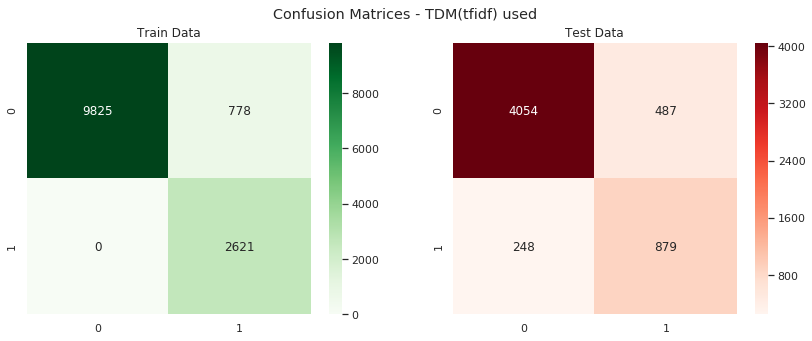

In [82]:
f,ax = plt.subplots(1,2, figsize=(14,5))
sns.heatmap(metrics.confusion_matrix(train_y, train_pred_tdm), annot=True, fmt='d', cmap='Greens', ax=ax[0])
ax[0].set_title('Train Data')
sns.heatmap(metrics.confusion_matrix(test_y, test_pred_tdm), annot=True, fmt='d', cmap='Reds', ax=ax[1])
ax[1].set_title('Test Data')
plt.suptitle('Confusion Matrices - TDM(tfidf) used')

Text(0.5, 1.0, 'Accuracy Scores (TDM) (Green=Train & Red = Test)')

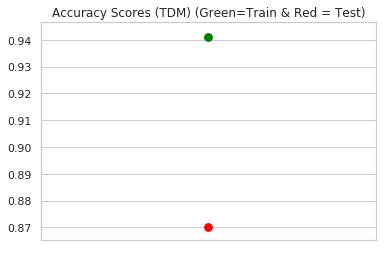

In [83]:
sns.pointplot(y=[metrics.accuracy_score(train_y,  train_pred_tdm)], color='Green', label='Train')
sns.pointplot(y=[metrics.accuracy_score(test_y, test_pred_tdm)], color = 'Red', label='Test')
plt.title('Accuracy Scores (TDM) (Green=Train & Red = Test)')

* we observe that using tf-idf over simple tf (term frequency) hasn't improved the results much

# Analysing Similar Jobs

* Performing topic modelling using LDA on JOB POST COLUMN

In [84]:
#creating tf-idf
tf_trans2 = TfidfVectorizer(analyzer='word', ngram_range=(1,1), strip_accents='unicode', stop_words='english', min_df = 0.05, max_df = 0.95)

In [85]:
# using LATENT DIRICHILET ALLOCATION
lda_topic = LDA(n_components=5, learning_method='online', max_iter=10, n_jobs=-1)  # 5 components or 5 topics/heads

In [86]:
jobpost_tfi = tf_trans2.fit_transform(job2.jobpost)

In [87]:
jobpost_tfi

<18892x518 sparse matrix of type '<class 'numpy.float64'>'
	with 1418250 stored elements in Compressed Sparse Row format>

In [88]:
text_topics = lda_topic.fit_transform(jobpost_tfi)

In [89]:
topics = lda_topic.components_
topic_vocab = tf_trans2.get_feature_names()

In [90]:
topic_summaries = []
for i, topic_dist in enumerate(topics):
    topic_words = np.array(topic_vocab)[np.argsort(topic_dist)][:-11:-1]
    topic_summaries.append(' '.join(topic_words))
topic_summaries

['software development design experience developer knowledge web test team testing',
 'accounting bank financial credit knowledge finance banking cjsc skills tax',
 'sales marketing skills knowledge work excellent russian english candidates manager',
 'project development program management international training activities implementation support experience',
 'network systems equipment technical security maintenance knowledge engineer engineering server']

### EXPLANATION
* from above we may conclude that most of the job postings may be grouped under the topic
    * software development & designing
    * sales & marketing
    * accounting & finance
    * project development & management
    * network security & systems engineer

Thank You
* C.Varun